In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import GridSearchCV

rn = 123

In [ ]:
reload(utils)

# Read data

In [2]:
df = pd.read_csv("..\\data\\train_fix.csv",index_col=False)
x_test = pd.read_csv("..\\data\\test_fix.csv",index_col=False)
df = df.drop(["Unnamed: 0"], axis=1)
x_test = x_test.drop("Unnamed: 0", axis=1)

In [3]:
dv = "Class"
y_train = df[dv]
x_train = df.drop([dv], axis=1)

# Models

## Logistic Regression

## SVM

In [56]:
from sklearn.svm import SVR

In [ ]:
# Grid search
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
parameters = {'C': [0.1], 'gamma': [1,0.1],'kernel': ['sigmoid']}
model = SVR() # we allow max number of iterations until the model converges
clf = GridSearchCV(model, parameters, scoring='accuracy') # neg_log_loss
clf.fit(x_train, y_train)
# Get best parameters
plt.plot(clf.cv_results_['mean_test_score'])
plt.xlabel(clf.cv_results_['params'])
plt.show()
print(clf.best_params_)


In [7]:
# model
model = SVR(C=10,gamma=1,kernel='poly')
model.fit(x_train, y_train)
# analysis
pred = model.predict(x_train)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_train, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# prediction
pred_test = pd.DataFrame(columns=['Id','class_0','class_1'])
pred_test['class_1'] = pd.DataFrame(model.predict(x_test))
pred_test['class_0'] = 1 - pred_test['class_1']

ID = pd.read_csv("test.csv",usecols=['Id'])
pred_test['Id'] = ID['Id']
 
pred_test.to_csv("submission.csv",index=False)
# kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

## Trees

In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb

### RF

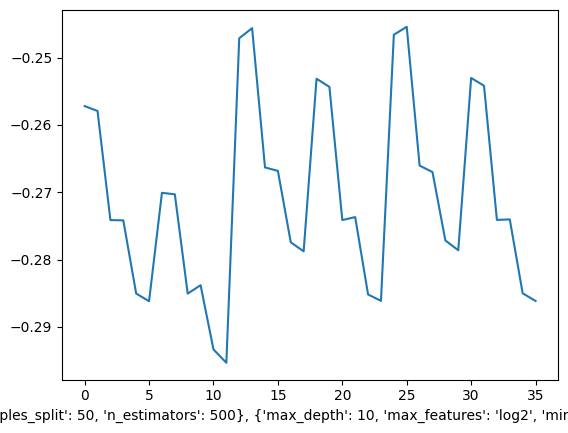

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}


In [5]:
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,10,20],
    'min_samples_split' :[10,30,50]
}
model = RandomForestClassifier(random_state=42)
clf = GridSearchCV(model, parameters, scoring='neg_log_loss',cv=5)
clf.fit(x_train, y_train)
# Get best parameters
plt.plot(clf.cv_results_['mean_test_score'])
plt.xlabel(clf.cv_results_['params'])
plt.show()
print(clf.best_params_)

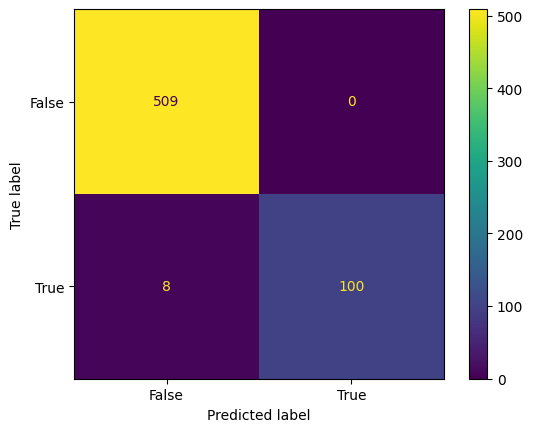

0.19697119507261124


In [54]:
# model
model = RandomForestClassifier(max_depth=20,max_features='sqrt',min_samples_split=10,n_estimators=500)
model.fit(x_train, y_train)
# analysis 
pred = model.predict(x_train)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_train, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Baanced log loss:
pred = pd.DataFrame(model.predict_proba(x_train), columns=clf.classes_)
# Amend 0s to avoid NaNs
pred.loc[pred[1]==0,1] = 1e-05
pred.loc[pred[0]==0,0] = 1e-05
pred.loc[pred[1]==1,1] = 1 - 1e-05
pred.loc[pred[0]==1,0] = 1 - 1e-05

ll = -(sum((y_train==1)*np.log(pred[1]))/sum(y_train==1)+sum((y_train==0)*np.log(pred[0]))/sum(y_train==0))/2
print(ll)

### XGBoost

In [58]:
import xgboost as xgb
import time

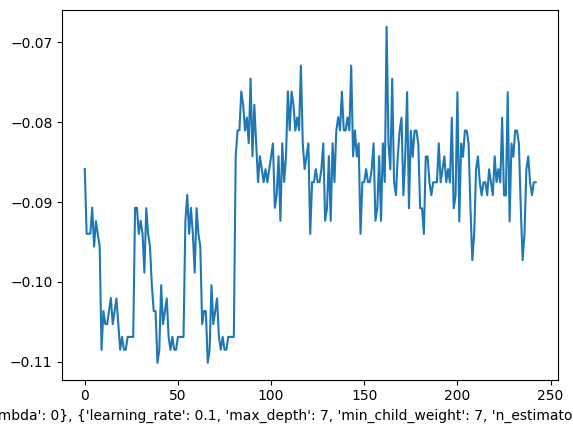

{'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
CPU times: total: 21min 6s
Wall time: 2min 28s


In [60]:
%%time

parameters = {'learning_rate': [.03, 0.1, .5], #so called `eta` value
              'max_depth': [5, 7, 10],
              'min_child_weight': [4, 7, 10],
              'n_estimators': [100],
              'reg_alpha': [0,0.1,0.7],
              'reg_lambda': [0,0.1,0.7]}
model = xgb.XGBClassifier(random_state=42)
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)
clf.fit(x_train, y_train)
# Get best parameters
plt.plot(clf.cv_results_['mean_test_score'])
plt.xlabel(clf.cv_results_['params'])
plt.show()
print(clf.best_params_)


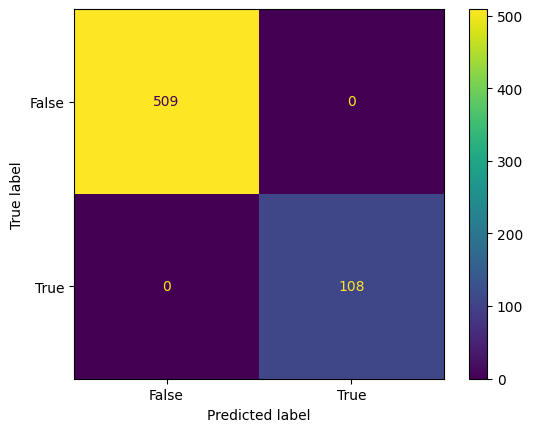

0.026630401260349136


In [61]:
# model
model = xgb.XGBClassifier(booster='gbtree', 
                          objective='binary:logistic',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          importance_type='gain',
                        #   colsample_bylevel=1,
                        #   colsample_bynode=1,
                        #   colsample_bytree=0.6,
                        #   gamma=0,
                        #   scale_pos_weight=1,
                        #   silent=None,
                        #   subsample=0.8,
                        #   nthread=None,
                        #   n_jobs=1,
                        #   max_delta_step=0,
                          learning_rate=0.5,
                          max_depth=5,
                          min_child_weight=4,
                          n_estimators=100,
                          reg_alpha=0,
                          reg_lambda=0,
                          verbosity=1)
model.fit(x_train, y_train)
# analysis 
pred = model.predict(x_train)
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_train, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Baanced log loss:
pred = pd.DataFrame(model.predict_proba(x_train), columns=clf.classes_)
# Amend 0s to avoid NaNs
pred.loc[pred[1]==0,1] = 1e-05
pred.loc[pred[0]==0,0] = 1e-05
pred.loc[pred[1]==1,1] = 1 - 1e-05
pred.loc[pred[0]==1,0] = 1 - 1e-05

ll = -(sum((y_train==1)*np.log(pred[1]))/sum(y_train==1)+sum((y_train==0)*np.log(pred[0]))/sum(y_train==0))/2
print(ll)